In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from pykdf.kdf import load_kdf
from pacological.bluemass5 import *
import numpy as np

In [113]:
# %load "/home/ejp/src/pacological/pars/pars_test_f10.py"

# For n we are summing over all e-types
pops = [('L1_E', {'n': 800,
                  'type': 'E',
                  'r_0': 8, 'bias' : 6e-3}), ('L1_I', {'n': 200,
                                        'type': 'I',
                                        'r_0': 12, 'bias' : 1e-3})]

inputs = [('L1_E', {'w': 8e-3,
                    'c': 1,
                    'n': 250,
                    'p': 0.1,
                    'tau_decay': 5e-3,
                    'type': 'E'})]

backs = [
    # L3
    ('L1_E', {'f': 10,
              'n_bursts': None,
              'min_r': 30,
              'r_e': 135,
              'r_i': 135,
              'w_e': 4e-9,
              'w_i': 48e-9,
              'tau_e': 5e-3,
              'tau_i': 10e-3}),
    ('L1_I', {'f': 0,
              'n_bursts': None,
              'min_r': 30,
              'r_e': 135,
              'r_i': 135,
              'w_e': 4e-9,
              'w_i': 16e-9,
              'tau_e': 5e-3,
              'tau_i': 10e-3}),
]

conns = [
    # Layer 1 -------------------------------------------------------
    # Internal
    ('L1_E', 'L1_E', {'tau_decay': 5e-3,
                      'tau_decay_std': 1e-3,
                      'w': 2e-3, # 2-5
                      'w_std': .11e-9,
                      'c': 1.0,
                      'c_std': 0.1,
                      'p': 0.1}),
    ('L1_E', 'L1_I', {'tau_decay': 5e-3,
                      'tau_decay_std': 1e-3,
                      'w': 2e-3, # 2
                      'w_std': .11e-9,
                      'c': 1.0,
                      'c_std': 0.1,
                      'p': 0.1}),
    ('L1_I', 'L1_E', {'tau_decay': 10e-3,
                      'tau_decay_std': 1e-3,
                      'w': 12e-3, # 6-20
                      'w_std': .11e-9,
                      'c': 1.0,
                      'c_std': 0.1,
                      'p': 0.2}),
    ('L1_I', 'L1_I', {'tau_decay': 10e-3,
                      'tau_decay_std': 1e-3,
                      'w': 3e-3, # 2
                      'w_std': .11e-9,
                      'c': 1.0,
                      'c_std': 0.1,
                      'p': 0.2})
]

In [114]:
seed = 42
save_path = "/home/ejp/src/pacological/data/test/tune"

pars = BMparams(pops, conns, backs, inputs, sigma=0, background_res=0, I_max=50e-3)

t = 1.0
dt = 1e-3
times = create_times(t, dt)

# Setup stimulus
d = 10
scale = .01 * d
stim = create_stim_I(times, d, scale,  seed=seed)
# stim = create_constant_I(times, d, seed=seed)

# Setup the network
gn = partial(ornstein_uhlenbeck, sigma=0.01, loc=[0])
fn, idxs = create_layers(times, stim, pars, seed=seed, verbose=False, debug=False)

# Init the intial values
ys0 = create_ys0(pars, idxs, frac=0.1)

# Integrate!
ys = itoint(fn, gn, ys0, times)

# -
save_kdf("{}".format(save_path),
     ys=ys,
     ys0=ys0,
     idx_R=idxs['R'],
     idx_IN=idxs['IN'],
     idx_INsigma=idxs['INsigma'],
     idx_H=idxs['H'],
     idx_Hsigma=idxs['Hsigma'],
     times=times,
     names=pars.names,
     t=t,
     dt=dt,
     d=d,
     stim=np.asarray([stim(t) for t in times]),
     seed=seed)

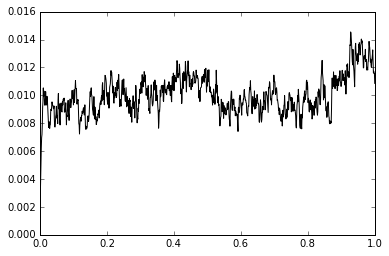

In [115]:
plt.plot(times, ys[:, idxs['IN']], label='IN', color='k')

(0, 0.3)

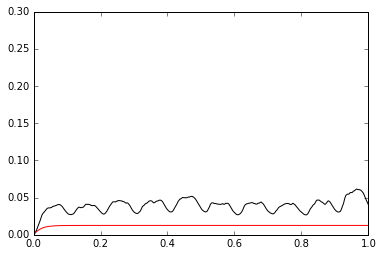

In [116]:
plt.plot(times, ys[:, idxs['R'][0]], color='k', label='E')
plt.plot(times, ys[:, idxs['R'][1]], color='r', label='I')
plt.ylim(0, .3)

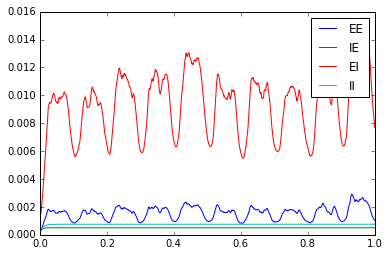

In [117]:
# plt.plot(times, ys[:, idxs['H']], label='E')
plt.plot(times, ys[:, idxs['H'][0]], label='EE')
plt.plot(times, ys[:, idxs['H'][1]], label='IE')
plt.plot(times, ys[:, idxs['H'][2]], label='EI')
plt.plot(times, ys[:, idxs['H'][3]], label='II')
plt.legend()